# CS6890: Assignment 1  

### Team Members:  
- **CS22BTECH11043** : Nethi Keerthana  
- **CS22BTECH11012** : Bolla Nehasree  
- **ES22BTECH11025** : N. Krishna Chaitanya  



### Importing the data

In [27]:
import pandas as pd

#Read the payments.xlsx file
payments = pd.read_excel("/home/hp/Downloads/Payments.xlsx", engine="openpyxl")
#print(payments.head())

#Read the bad_sender.xlsx file
bad_senders = pd.read_excel("/home/hp/Downloads/bad_sender.xlsx", engine="openpyxl")
#print(bad_senders.head())

### Import the pregel.py code 

In [28]:
"""pregel.py is a python 2.6 module implementing a toy single-machine
version of Google's Pregel system for large-scale graph processing."""

import collections
import threading

class Vertex():

    def __init__(self,id,value,out_vertices):
        # This is mostly self-explanatory, but has a few quirks:
        #
        # self.id is included mainly because it's described in the
        # Pregel paper.  It is used briefly in the pagerank example,
        # but not in any essential way, and I was tempted to omit it.
        #
        # Each vertex stores the current superstep number in
        # self.superstep.  It's arguably not wise to store many copies
        # of global state in instance variables, but Pregel's
        # synchronous nature lets us get away with it.
        self.id = id 
        self.value = value
        self.out_vertices = out_vertices
        self.incoming_messages = []
        self.outgoing_messages = []
        self.active = True
        self.superstep = 0
   
   
class Pregel():

        def __init__(self,vertices,num_workers):
            self.vertices = vertices
            self.num_workers = num_workers

        def run(self):
            """Runs the Pregel instance."""
            self.partition = self.partition_vertices()
            while self.check_active():
                self.superstep()
                self.redistribute_messages()

        def partition_vertices(self):
            """Returns a dict with keys 0,...,self.num_workers-1
            representing the worker threads.  The corresponding values are
            lists of vertices assigned to that worker."""
            partition = collections.defaultdict(list)
            for vertex in self.vertices:
                partition[self.worker(vertex)].append(vertex)
            return partition

        def worker(self,vertex):
            """Returns the id of the worker that vertex is assigned to."""
            return hash(vertex) % self.num_workers

        def superstep(self):
            """Completes a single superstep.  

            Note that in this implementation, worker threads are spawned,
            and then destroyed during each superstep.  This creation and
            destruction causes some overhead, and it would be better to
            make the workers persistent, and to use a locking mechanism to
            synchronize.  The Pregel paper suggests that this is how
            Google's Pregel implementation works."""
            workers = []
            for vertex_list in self.partition.values():
                worker = Worker(vertex_list)
                workers.append(worker)
                worker.start()
            for worker in workers:
                worker.join()

        def redistribute_messages(self):
            """Updates the message lists for all vertices."""
            for vertex in self.vertices:
                vertex.superstep +=1
                vertex.incoming_messages = []
            for vertex in self.vertices:
                for (receiving_vertix,message) in vertex.outgoing_messages:
                    receiving_vertix.incoming_messages.append((vertex,message))

        def check_active(self):
            """Returns True if there are any active vertices, and False
            otherwise."""
            return any([vertex.active for vertex in self.vertices])

class Worker(threading.Thread):

    def __init__(self,vertices):
        threading.Thread.__init__(self)
        self.vertices = vertices

    def run(self):
        self.superstep()

    def superstep(self):
        """Completes a single superstep for all the vertices in
        self."""
        for vertex in self.vertices:
            if vertex.active:
                vertex.update()

### Trust Rank ALgorithm  

In [29]:
import pandas as pd
import numpy as np
from collections import defaultdict

# Declare vertices globally
vertices = {}

#Define a class
class TrustRankVertex(Vertex):
    def __init__(self, id, value, random_page_prob, damping_factor=0.85, num_iterations=100):
        self.id = id
        self.value = value
        self.random_page_prob = random_page_prob  
        self.out_vertices = []  
        self.edge_weights = {}  
        self.damping_factor = damping_factor
        self.num_supersteps = num_iterations
        self.active = True
        self.superstep = 0
        self.incoming_messages = []
        self.outgoing_messages = []

    def update(self):
        if self.superstep < self.num_supersteps:
            trust_sum = 0
            edge_weights = np.array([self.edge_weights[vertex_id] for vertex_id in self.out_vertices if vertex_id in self.edge_weights])

            for (vertex, message) in self.incoming_messages:
                trust_sum += message

            # Update the trust value 
            self.value = self.damping_factor * trust_sum + (1 - self.damping_factor) * self.random_page_prob

            # Update outgoing messages
            self.outgoing_messages = [
                (vertices[vertex_id], self.value * weight) 
                for vertex_id, weight in zip(self.out_vertices, edge_weights)
            ]
        else:
            self.active = False

    @staticmethod
    def create_vertices(payments, bad_senders):
        # Declare the global variable
        global vertices  
        # Declare the pr_pregel variable
        global pr_pregel
        
        # Extract unique senders, receivers, and bad nodes
        senders = set(payments["Sender"].unique())
        receivers = set(payments["Receiver"].unique())
        bad_nodes = set(bad_senders["Bad Sender"].unique())
        all_nodes = senders | receivers | bad_nodes  # Union operation for efficiency

        # Initialize vertices with proper parameters
        initial_value = 1.0 / len(bad_nodes) if bad_nodes else 0.0  

        vertices = {
            node: TrustRankVertex(node, (1.0 / len(bad_nodes)) if node in bad_nodes else 0.0, initial_value, 0.85, 10)
            for node in all_nodes
        }
        
         # Build the graph: Store outgoing edges and compute edge weights
        for _, row in payments.iterrows():
            sender = row["Sender"]
            receiver = row["Receiver"]
            amount = row["Amount"]

            if sender in vertices and receiver in vertices:
                if receiver not in vertices[sender].out_vertices:
                    vertices[sender].out_vertices.append(receiver)
                    vertices[sender].edge_weights[receiver] = amount
                else:
                    # If multiple transactions exist, accumulate the weight
                    vertices[sender].edge_weights[receiver] += amount

        # Ensure every vertex with no outgoing edges connects to all bad nodes
        for node in all_nodes:
            if node in vertices and not vertices[node].out_vertices:
                for bad_node in bad_nodes:
                    if bad_node in vertices: 
                        vertices[node].out_vertices.append(bad_node)
                        vertices[node].edge_weights[bad_node] = 1.0/len(bad_senders)  # Assign equal initial weight to bad nodes


        '''# Print only edges where node 1309 is the sender, sorted
        target_node = 1133

        filtered_edges = sorted(
            (neighbor, weight)  # Sort by receiver
            for neighbor, weight in vertices[target_node].edge_weights.items()
        )

        # Compute the total sum of outgoing edge weights from sender 1309
        total_weight = sum(weight for _, weight in filtered_edges)

        print(f"\nEdges Sent by Node {target_node} (Sorted by Receiver):")
        for neighbor, weight in filtered_edges:
            print(f"Edge ({target_node} -> {neighbor}): {weight:.6f}")

        print(f"\nTotal Sum of Outgoing Edges before normalization from {target_node}: {total_weight:.6f}")'''

        # Normalize edge weights for each node
        for node, vertex in vertices.items():
            total_weight = sum(vertex.edge_weights.values())
            if total_weight > 0:
                vertex.edge_weights = {k: v / total_weight for k, v in vertex.edge_weights.items()}  # Normalize weights

       # Print normalized edge weights
        '''print("\nEdge Weights After Normalization:")
        for node, vertex in vertices.items():
            for neighbor, weight in vertex.edge_weights.items():
                print(f"Edge ({node} -> {neighbor}): {weight:.6f}")'''

        # Compute the pagerank vector
        vertices_list = list(vertices.values())
        pr_pregel = trustrank_pregel(vertices_list)
        
        # Normalize the final trust rank values
        pr_pregel = pr_pregel / np.sum(pr_pregel)
        
        # Create a list of (node_id, trust_rank) tuples
        rank_values = [(vertex.id, trust_rank.item()) for vertex, trust_rank in zip(vertices_list, pr_pregel)]

        # Sort the rank values based on the node ID
        sorted_rank_values = sorted(rank_values, key=lambda x: x[0]) 

        # Print the sorted trust rank values along with node IDs
        print("\nSorted Trust Rank Values (Node ID along with Rank):")
        for node_id, trust_rank in sorted_rank_values:
            print(f"Node {node_id}: {trust_rank:.6f}")  
        total_sum = np.sum(pr_pregel)
        print(f"Sum of elements of pr_pregel: {total_sum:.6f}")


def trustrank_pregel(vertices):
    """Computes the pagerank vector associated to vertices, using Pregel."""
    p = Pregel(vertices, num_workers=4)
    p.run()
    return np.mat([vertex.value for vertex in p.vertices]).transpose()

def main():
    TrustRankVertex.create_vertices(payments, bad_senders)

if __name__ == "__main__":
    main()



Sorted Trust Rank Values (Node ID along with Rank):
Node 1001: 0.002956
Node 1002: 0.000799
Node 1003: 0.000687
Node 1004: 0.004331
Node 1005: 0.003092
Node 1006: 0.001175
Node 1007: 0.035610
Node 1008: 0.002350
Node 1009: 0.000234
Node 1010: 0.001435
Node 1011: 0.005954
Node 1012: 0.000234
Node 1013: 0.006009
Node 1014: 0.002539
Node 1015: 0.000241
Node 1016: 0.006456
Node 1017: 0.000235
Node 1018: 0.000631
Node 1019: 0.000246
Node 1020: 0.002170
Node 1021: 0.007295
Node 1022: 0.000243
Node 1023: 0.002330
Node 1024: 0.000246
Node 1025: 0.004319
Node 1026: 0.000634
Node 1027: 0.004187
Node 1028: 0.001087
Node 1029: 0.000440
Node 1030: 0.000480
Node 1031: 0.003746
Node 1032: 0.000240
Node 1033: 0.004729
Node 1034: 0.010639
Node 1035: 0.002839
Node 1036: 0.002066
Node 1037: 0.007967
Node 1038: 0.008017
Node 1039: 0.006020
Node 1040: 0.001540
Node 1041: 0.007242
Node 1042: 0.007910
Node 1043: 0.006489
Node 1044: 0.000237
Node 1045: 0.000234
Node 1046: 0.000260
Node 1047: 0.000234
Node 10

### Plot the results 

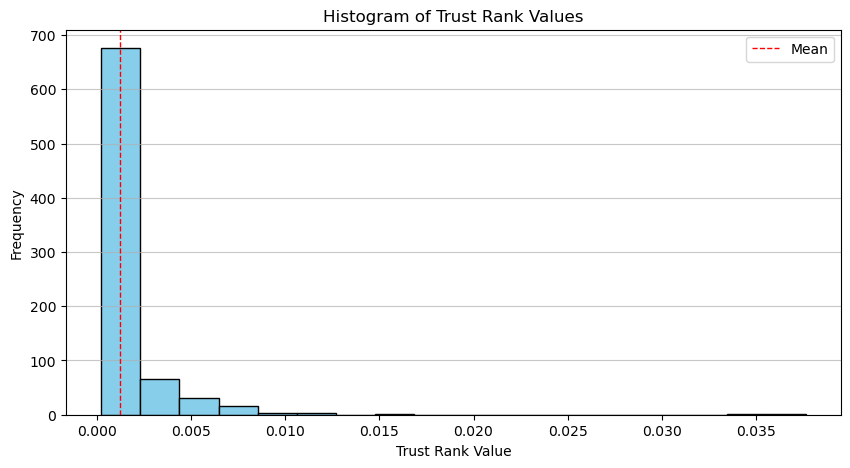

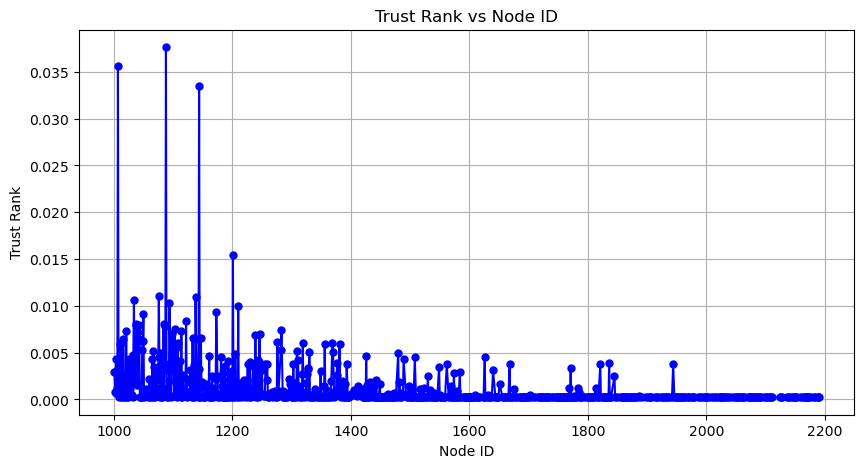

In [30]:
import numpy as np
import matplotlib.pyplot as plt

def plot_trust_rank_histogram(trust_rank_values):
    """Plot a histogram of Trust Rank values."""
    plt.figure(figsize=(10, 5))
    plt.hist(trust_rank_values, bins=18, color='skyblue', edgecolor='black')
    plt.title('Histogram of Trust Rank Values')
    plt.xlabel('Trust Rank Value')
    plt.ylabel('Frequency')
    plt.grid(axis='y', alpha=0.7)
    plt.axvline(np.mean(trust_rank_values), color='red', linestyle='dashed', linewidth=1, label='Mean')
    plt.legend()
    plt.show()

def plot_trust_rank_vs_id(pr_pregel, vertices):
    """Plot Trust Rank values against Node IDs."""
    # Create a list of (node_id, trust_rank) tuples
    rank_values = [(vertex.id, trust_rank.item()) for vertex, trust_rank in zip(vertices, pr_pregel)]

    # Sort by Node ID
    sorted_rank_values = sorted(rank_values, key=lambda x: x[0])
    
    # Extract sorted node IDs and trust ranks
    node_ids, trust_ranks = zip(*sorted_rank_values)

    # Plot Trust Rank vs Node ID
    plt.figure(figsize=(10, 5))
    plt.plot(node_ids, trust_ranks, marker='o', linestyle='-', color='blue', markersize=5)
    plt.title('Trust Rank vs Node ID')
    plt.xlabel('Node ID')
    plt.ylabel('Trust Rank')
    plt.grid(True)
    plt.show()

# Compute the PageRank vector
vertices_list = list(vertices.values())
trust_rank_values = [trust_rank.item() for trust_rank in pr_pregel]

# Plot both graphs
plot_trust_rank_histogram(trust_rank_values)
plot_trust_rank_vs_id(pr_pregel, vertices_list)

  
